<a href="https://www.kaggle.com/code/haiderjan/health-diagnosis-and-fault-detection-of-bearings?scriptVersionId=107130370" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/industrial-bearing-dataset/dataset_for_team/data_train.mat
/kaggle/input/industrial-bearing-dataset/dataset_for_team/BDsom2.mat
/kaggle/input/industrial-bearing-dataset/dataset_for_team/Tsom2.mat
/kaggle/input/industrial-bearing-dataset/dataset_for_team/data_test.mat
/kaggle/input/industrial-bearing-dataset/dataset_for_team/data_train_labels.mat
/kaggle/input/industrial-bearing-dataset/dataset_for_team/Readme.txt
/kaggle/input/industrial-bearing-dataset/dataset_for_team/final_idx.mat
/kaggle/input/industrial-bearing-dataset/dataset_for_team/data_test_labels.mat


<h2>Importing all the Required Libraries </h2>


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, chirp
import numpy as np
import scipy.io
from scipy.fft import fft, ifft
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import warnings
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Defining the Logistic ALgorithm Framework

In [3]:

#0: setosa
#1: non-setosa (versicolor & virginica)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def param_init(X): 

    params = {} # initialize dictionary 
    _, n_features = X.shape # shape of training data

    # initializing coefficents to 0 
    params["W"] = np.zeros(n_features)
    params["b"] = 0
    return params

# Calculates the linear function V'
# X: Training Data
# W: Weight coefficients
# b: bias coefficients
def get_z(X, W, b): 

    z = np.dot(X, W) + b
    return z

# X: Training Data
# y: Labels
# params: Dictionary containing coefficients
# lr: learning rate


# Gradient Descent

In [4]:
def gradient_descent(X, y, params, lr, n_iter): 

    W = params["W"] 
    b = params["b"]
    m = X.shape[0] # number of training instances 

    for _ in range(n_iter): 
        # prediction with random weights
        g = sigmoid(get_z(X, W, b))
        # calculate the loss
        loss = -1/m * np.sum(y * np.log(g)) + (1 - y) * np.log(1-g)
        # partial derivative of weights 
        dW = 1/m * np.dot(X.T, (g - y))
        db = 1/m * np.sum(g - y)
        # updates to coefficients
        W -= lr * dW
        b -= lr * db 
    
    params["W"] = W
    params["b"] = b
    return params

# Training and Prediction

In [5]:
# X: Training Data
# y: Labels
# lr: learning rate
# n_iter: Number of iterations
def train(X, y, lr=0.01, n_iter=1000):

    init_params = param_init(X)
    params = gradient_descent(X, y, init_params, lr, n_iter)
    return params

# X_test: Unseen data
def predict(X_test, params):

    z = np.dot(X_test, params["W"]) + params["b"]
    y_pred = sigmoid(z) >= 0.1
    return y_pred.astype("int")


# Importing all Data 

In [6]:
mat_train= scipy.io.loadmat('../input/industrial-bearing-dataset/dataset_for_team/data_train.mat')
mat_test= scipy.io.loadmat('../input/industrial-bearing-dataset/dataset_for_team/data_test.mat')
data_train=mat_train['data_train'][0]
data_test=mat_test['data_test'][0]
data_train=[a.flatten() for a in data_train]
data_test=[a.flatten() for a in data_test]
data_train=np.array(data_train)
data_test=np.array(data_test)

###Labels

labels_train = scipy.io.loadmat('../input/industrial-bearing-dataset/dataset_for_team/data_train_labels.mat')
labels_train=labels_train['data_train_labels']
labels_test = scipy.io.loadmat('../input/industrial-bearing-dataset/dataset_for_team/data_test_labels.mat')
labels_test=labels_test['data_test_labels']

In [7]:
data_train.shape

(2048, 8192)

# Feature Matrix

In [8]:
def feature_matrix_generator(df):
  df_hilbert=np.array([np.abs(hilbert(df[i])) for i in range(df.shape[0])])
  df_hilbert_centralized=[df_hilbert[i]-np.mean(df_hilbert[i]) for i in range(df_hilbert.shape[0])]
  df_hilbert_centralized=np.array(df_hilbert_centralized)

  df_fft=np.array([np.abs(fft(df_hilbert_centralized[i])) for i in range(df_hilbert_centralized.shape[0])])
  shape_df=df_fft[0].shape[0]/2
  df_fft=np.array([df_fft[i][0:int(shape_df)] for i in range(df_fft.shape[0])])

  Fs = 50000;
  N=df_fft[0].shape[0]
  T_total=N*1/Fs
  d_f=1/T_total
  frequency_vector=np.arange(0,Fs-d_f,d_f)

  feature_matrix=pd.DataFrame()
  feature_matrix['first_harmonic']=np.array([df_fft[j][(frequency_vector>10) & (frequency_vector<20)] for j in range(df_fft.shape[0]) ]).flatten()
  feature_matrix['second_harmonic']=np.array([df_fft[j][(frequency_vector>90) & (frequency_vector<100)] for j in range(df_fft.shape[0]) ]).flatten()
  feature_matrix['third_harmonic']=np.array([df_fft[j][(frequency_vector>126) & (frequency_vector<136)] for j in range(df_fft.shape[0]) ]).flatten()
  feature_matrix['forth_harmonic']=np.array([df_fft[j][(frequency_vector>20) & (frequency_vector<30)] for j in range(df_fft.shape[0]) ]).flatten()

  return feature_matrix

# Training and Testing Data

In [9]:
feature_matrix_train=feature_matrix_generator(data_train)
feature_matrix_test=feature_matrix_generator(data_test)

In [10]:
#For the health assessment all labels with 1s are Healthy and rest are faulty, so we number our data accordingly while going downb each layer in fault detection
#Insha Allah when I'm compiling this code, I'll get to it.
(labels_train[0]==1)

array([ True,  True,  True, ..., False, False, False])

In [11]:
feature_matrix_train['label']=(labels_train[0]==1)*1
feature_matrix_test['label']=(labels_test[0]==1)*1

In [12]:
params_health_assestment = train(feature_matrix_train.iloc[:,:-1], feature_matrix_train.iloc[:,-1]) # train model

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


In [13]:
y_healthy_faulty_test_hat=predict(feature_matrix_test.iloc[:,:-1], params_health_assestment)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


In [14]:
y_healthy_faulty_test_hat

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [15]:
accuracy_score(feature_matrix_test.iloc[:,-1], y_healthy_faulty_test_hat)

0.87890625

# Faulty 2

In [16]:
# Getting the ids of data labelled from 2 to 8
idx=feature_matrix_train[feature_matrix_train['label']==0].index

feature_matrix_train_fault2=feature_matrix_train.iloc[idx,:]
labels_train_fault2=labels_train[0][idx]
feature_matrix_train_fault2['label']=np.abs((labels_train_fault2==2)*1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
params_fault2 = train(feature_matrix_train_fault2.iloc[:,:-1], feature_matrix_train_fault2.iloc[:,-1])
y_fault2_test_hat=predict(feature_matrix_test.iloc[:,:-1], params_fault2)

#Precidtion
accuracy_score(feature_matrix_test.iloc[:,-1], y_fault2_test_hat)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


0.79296875

# Fault 3

In [18]:
idx=feature_matrix_train_fault2[feature_matrix_train_fault2['label']==0].index
feature_matrix_train_fault3=feature_matrix_train.iloc[idx,:]
labels_train_fault3=labels_train[0][idx]
feature_matrix_train_fault3['label']=np.abs((labels_train_fault3==3)*1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [19]:
params_fault3 = train(feature_matrix_train_fault3.iloc[:,:-1], feature_matrix_train_fault3.iloc[:,-1]) # train model
y_fault3_test_hat=predict(feature_matrix_test.iloc[:,:-1], params_fault3)
accuracy_score(feature_matrix_test.iloc[:,-1], y_fault3_test_hat)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


0.83203125

# Fault 4

In [20]:
idx=feature_matrix_train_fault3[feature_matrix_train_fault3['label']==0].index
feature_matrix_train_fault4=feature_matrix_train.iloc[idx,:]
labels_train_fault4=labels_train[0][idx]
feature_matrix_train_fault4['label']=np.abs((labels_train_fault4==4)*1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [21]:
params_fault4 = train(feature_matrix_train_fault4.iloc[:,:-1], feature_matrix_train_fault4.iloc[:,-1]) # train model
y_fault4_test_hat=predict(feature_matrix_test.iloc[:,:-1], params_fault4)
accuracy_score(feature_matrix_test.iloc[:,-1], y_fault4_test_hat)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


0.849609375

In [22]:
# y_healthy_faulty_test_hat
# y_fault2_test_hat
# y_fault3_test_hat
# y_fault4_test_hat
# y_fault2_test_hat[y_fault2_test_hat==1]=2
# y_fault3_test_hat[y_fault3_test_hat==1]=3
# y_fault4_test_hat[y_fault4_test_hat==1]=4

y_fault4_test_hat[y_healthy_faulty_test_hat==1]=1
y_fault4_test_hat[y_fault4_test_hat==0]=5
labels_test[(labels_test>4) | (labels_test==0)]=5

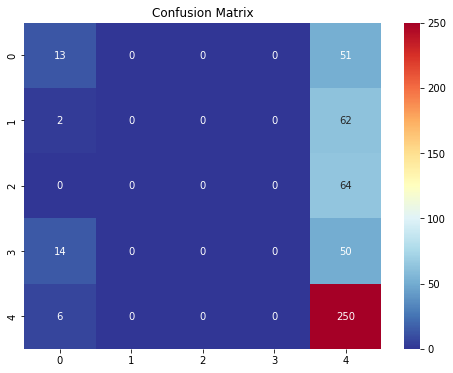

In [23]:
y_true = labels_test[0]
y_pred = y_fault4_test_hat
ext_data_corrs=confusion_matrix(y_true, y_pred)

plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, annot = True,fmt='d')
plt.title('Confusion Matrix');